# Classification of Machine Status 

Objective: To develop a classification model with high sensitivity (recall) to predict whether a machine is in working condition or faulty condition 






- The average cost of lost revenue and idle staff due to unplanned downtime machine failure is \\$ 532,000 per hour which is \\$ 172 million per plant annually. https://www.automation.com/en-us/articles/june-2021/world-largest-manufacturers-lose-almost-1-trillion

- Hence showing the importance of minimising false negatives in our prediction as each machine that fail means millions lost for the company.


- There is also a need to prevent too many false positive as money is still wasted to fix the machine.


- As the cost of machine failure during production exceed that of fixing the machine.


$$
Precision = \frac{TP}{TP+FP}
$$

$$
Recall = \frac{TP}{TP+FN}
$$



$$
F_2 = 5 * \frac{precision*recall}{4 * precision + recall} = \frac{TP}{TP + 0.2FP + 0.8FN}
$$

Hence we will use F2 Score throughout

In [1]:
import phik
import pandas as pd 
%matplotlib inline
from sklearn.preprocessing import RobustScaler ,StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns 
from sklearn.base import clone 

import plotly.express as px
import numpy as a
rng = a.random.RandomState(228)
import warnings 
import numpy as np 
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("factory_data (classification).csv")
data.drop(columns = ['Unique ID' , 'Product ID'] , inplace =True)
data

Quality  Ambient T (C)  Process T (C)  Rotation Speed (rpm)  \
0           M          24.95          35.45                1551.0   
1           L          25.05          35.55                1408.0   
2           L          24.95          35.35                1498.0   
3           L          25.05          35.45                1433.0   
4           L          25.05          35.55                1408.0   
...       ...            ...            ...                   ...   
19995       M          25.75          35.35                   NaN   
19996       H          25.85          35.35                1632.0   
19997       M          25.95            NaN                   NaN   
19998       H          25.95          35.65                1408.0   
19999       M          25.95          35.65                1500.0   

       Torque (Nm)  Tool Wear (min)  Machine Status  
0             42.8                0               0  
1             46.3                3               0  
2             49.4                5               0  
3             39.5                7               0  
4             40.0                9               0  
...            ...              ...             ...  
19995         29.5               14               0  
19996         31.8               17               0  
19997         33.4               22               0  
19998         48.5               25               0  
19999         40.2               30               0  

[20000 rows x 7 columns]

## Missing Values

#### No of Missing values 

In [3]:
data.isnull().sum()

Quality                  991
Ambient T (C)              0
Process T (C)            400
Rotation Speed (rpm)    1188
Torque (Nm)                0
Tool Wear (min)            0
Machine Status             0
dtype: int64

#### percentage of missing values

In [4]:
100*data.isnull().sum()/data.shape[0]

Quality                 4.955
Ambient T (C)           0.000
Process T (C)           2.000
Rotation Speed (rpm)    5.940
Torque (Nm)             0.000
Tool Wear (min)         0.000
Machine Status          0.000
dtype: float64

In [5]:
print(f"{100*(data.shape[0] - data.dropna().shape[0]) / data.shape[0]}% of rows will be lost when missing data is dropped")

12.355% of rows will be lost when missing data is dropped


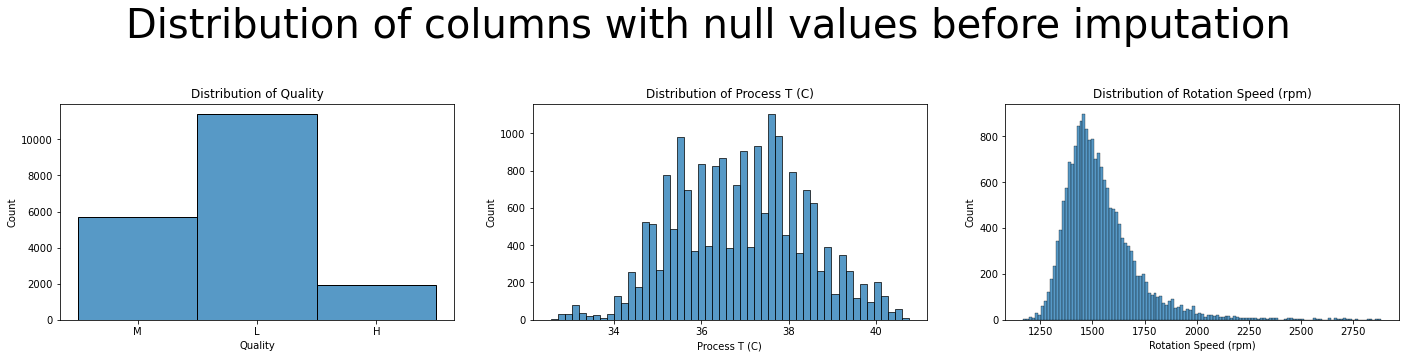

In [6]:
nulcols =  data.isnull().sum()[data.isnull().sum() != 0 ].index
plt.figure(figsize=(16*1.5,9*1.5))
plt.gcf().suptitle( 'Distribution of columns with null values before imputation' , fontsize = 40)
for i, col in enumerate(data.isnull().sum()[data.isnull().sum() != 0 ].index):
 
    ax = plt.subplot(3,3,i+1)
    ax.set_title( f'Distribution of {col}' )
    sns.histplot( ax =ax , data  = data , x = col)
plt.show() 

These are the existing distributions of these features with null values. <br> 
Attempt to choose a imputation method that does not the alter the distribution <br> 
Mean/median/mode Imputation will not be accurate as the distributions are not gaussian (positively skwed distribution of rotation speed) 
Multivariate imputation should be  used for better accurary with `Iterative Imputer `


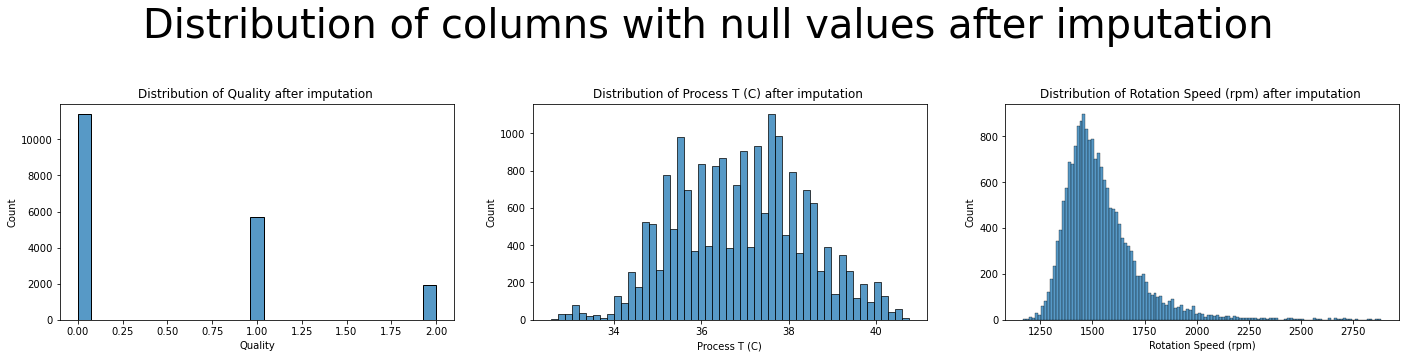

In [7]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import  HistGradientBoostingRegressor , BaggingClassifier  
from sklearn.base import BaseEstimator,TransformerMixin
class CustomImputation(BaseEstimator,TransformerMixin):
    '''custom imputation object that can be placed into sklearn pipeline'''
    def __init__(self,regressor, classifier):
        self.regressor = regressor
        self.classifier = classifier

    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        x_copy = X.copy()

        x_copy['Quality'] =  x_copy['Quality'].astype('i' ,  errors='ignore')
        original_quality = x_copy['Quality'].copy()
        temp = IterativeImputer(estimator = self.regressor, random_state=rng).fit_transform(x_copy) #impute numercial features  machine quality here 
        x_copy[:] = temp
        x_copy["Quality"] = original_quality



        without_null = x_copy[~x_copy.Quality.isnull()].copy()
        without_null.Quality = without_null.Quality.astype('i')
        withnull  = x_copy[x_copy.Quality.isnull()]
        fittedmodel = self.classifier.fit(without_null.drop(columns = ['Quality'])  ,without_null.Quality)
        predictions = fittedmodel.predict(withnull.drop(columns = ['Quality']))

        x_copy.loc[x_copy.Quality.isnull(), 'Quality']  = predictions 

        return x_copy

data['Quality'] = data['Quality'].map({'L' : 0 , "M" : 1 , 'H' : 2})
imputer = CustomImputation( HistGradientBoostingRegressor( random_state = rng ) ,  BaggingClassifier(n_jobs = -1 ,random_state = rng)  )
imputed =  imputer.transform(X = data )
plt.figure(figsize=(16*1.5,9*1.5))
plt.gcf().suptitle( 'Distribution of columns with null values after imputation' , fontsize = 40)
for i, col in enumerate(data.isnull().sum()[data.isnull().sum() != 0 ].index):
    ax = plt.subplot(3,3,i+1)
    ax.set_title( f'Distribution of {col} after imputation ' )
    sns.histplot( ax =ax , data  = data , x = col)

plt.show() 

The distribution looks to be largely unchanged by the imputer

The torque is roughly defined as the 'turning effect' of the machine, so plot scatter plot torque and rotation speed to see relation ship between those 2 variables


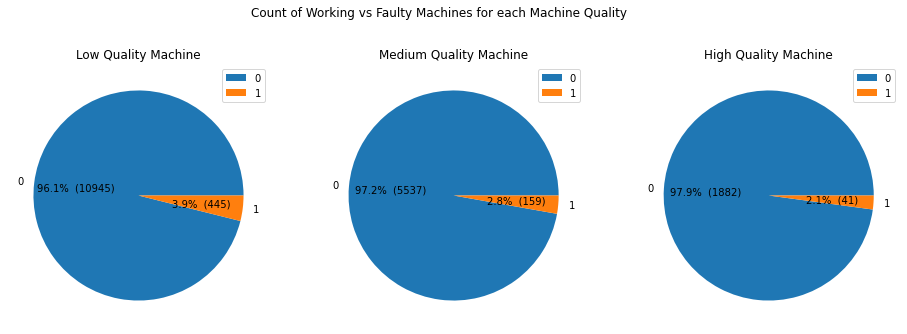

In [9]:
mid = data.sort_values('Machine Status' ).groupby('Quality')['Machine Status'].value_counts().to_frame().rename(columns = {'Machine Status' : 'counts'}).reset_index()
mid.Quality = mid.Quality.map({ 0 : 'L' , 1 : "M"  , 2 : 'H' })
fig , axs = plt.subplots( ncols = 3 , figsize = (16,5.5)) 
def percent(values):
    def my_autopct(pct):
    
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v})'.format(p=pct,v=val)
    return my_autopct
mapping = {'H' : "High" , "L" :  "Low" , 'M' : "Medium"}
for quality  , ax in zip(['L' , 'M' , 'H'], axs):
    tempdf = mid[mid.Quality == quality]
    ax.set_title(mapping[quality] + ' Quality Machine')
    ax.pie(x = tempdf.counts , labels = tempdf['Machine Status'] , autopct = percent(tempdf.counts) )
    ax.legend()
  #  tempdf.plot.pie(ax  = ax , y = 'counts')
fig.suptitle( "Count of Working vs Faulty Machines for each Machine Quality")
fig.set_facecolor('white')
plt.show()

0 represent machine in working condition and 1 represent machine is faulty 
## Unbalanced classes
- This dataset has unbalanced classes , (a lot of negative examples , very little positive examples) , which means accuracy as scoring metric cannot be used for modelling later (more on metrics below)
- Unbalanced classes should be deal with during modeling later

## 
- Machines with higher quality have slightly larger percentages of machines that are faulty , which are 2.1% ,  2.8% and 3.8% for High , medium and low quality machines respectively ,
- As the percentages are similar, it is difficult to tell whether there is an association between quality and machine status,
- hence,  chi square test at significance level of 5% is used to verify whether such relationship exists

## Chi-Test Test for Association

In [10]:
from sklearn.feature_selection import chi2 
chitemp = imputed[['Quality' , 'Machine Status']]
chi2_value, pvalue  = chi2( chitemp.Quality.to_frame() , chitemp[['Machine Status']] )
print( 'The chi2 value is ' ,np.round(chi2_value , 2 )[0] ,  'the p value is ' , np.round(pvalue,9 )[0] , 'between Quality and Machine Status' )

The chi2 value is  24.77 the p value is  6.47e-07 between Quality and Machine Status


- The pvalue which is close to 0 shows there is a association between quality and machine status
- Quality can be used in our model

interval columns not set, guessing: ['Quality', 'Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)', 'Machine Status']
interval columns not set, guessing: ['Quality', 'Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)', 'Machine Status']


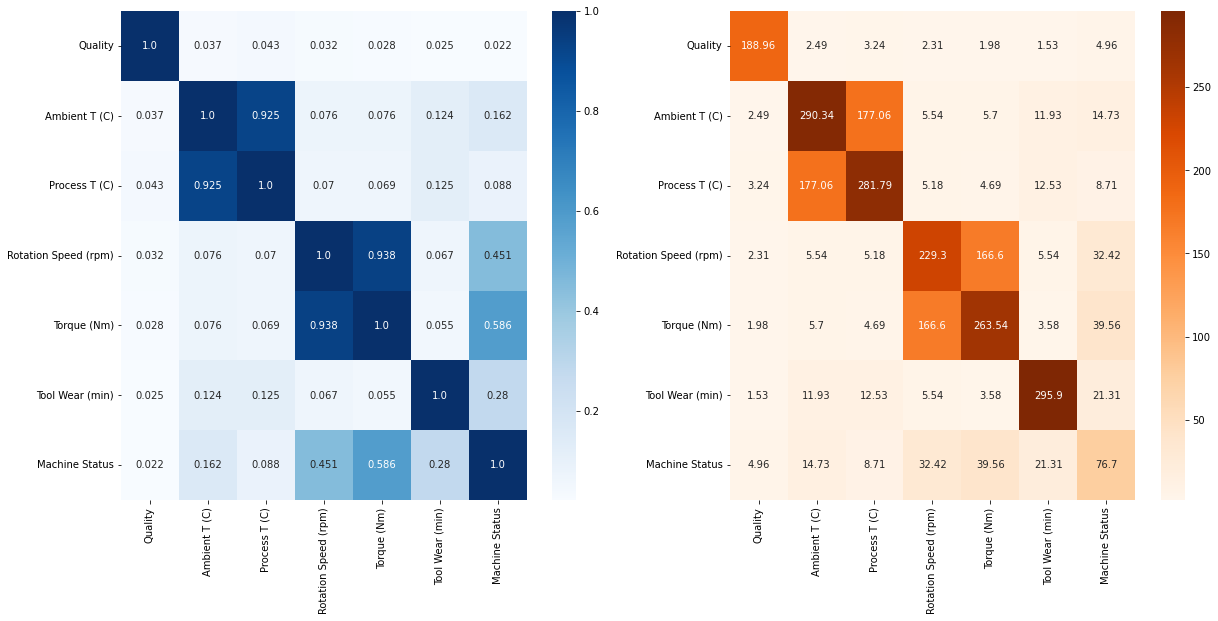

In [11]:
plt.figure( figsize = ( 20,9))
plt.title( 'phik correlation for each')
corr = np.round(imputed.phik_matrix()  , 3 ) 
plt.subplot(121)
sns.heatmap(corr, fmt = ''  , cmap="Blues"  , annot = corr)
plt.subplot(122)
sig = np.round(imputed.significance_matrix()  , 2 )

sns.heatmap(sig, fmt = ''  , cmap="Oranges"  , annot = sig.astype('string') )

plt.show()


- Most features are independant of each other
- There are 2 sets of features that are highly  correlated  with each other significantly

 1. `process (T)` and `ambient (t)` 
 2. `Torque` and `Rotation Speed`
- Highly correlated features (Multicollinearity) decreases the accuracy of distance based models like K nearest neighbours, logistic regression , neural network 
- Hence, they must be tranformed by PCA or one feature from each pair of multicollinearity must be removed

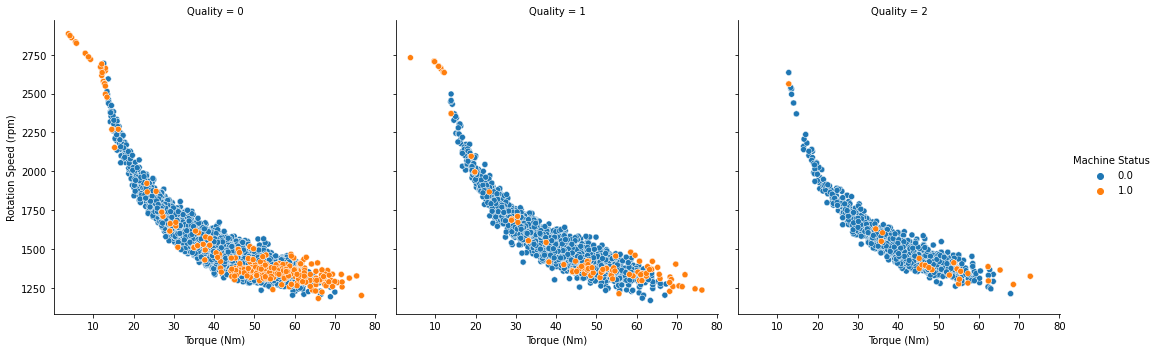

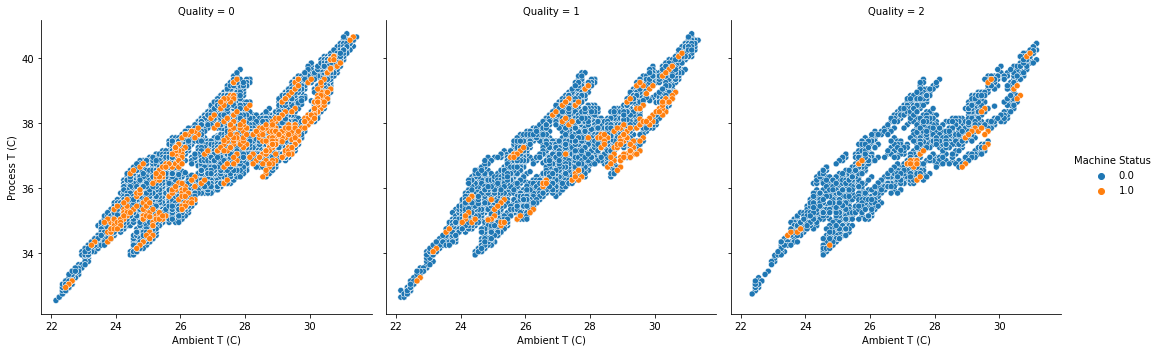

In [12]:
datacopy = data.copy()
sns.relplot( x= 'Torque (Nm)' , y = 'Rotation Speed (rpm)' , data = imputed.sort_values('Machine Status' )  , hue = 'Machine Status' , col = 'Quality' , col_order = [0,1,2])

sns.relplot( x= 'Ambient T (C)',  y = 'Process T (C)' , data = imputed.sort_values('Machine Status' )  , hue = 'Machine Status' , col = 'Quality' , col_order = [0,1,2])

    #ax.plot( range(22, 41) , range(22, 41))
plt.show()

- These 2 features of rotation speed and torque and (ambient and process temperature) are highly correlated with each other
- PCA can be used to transform each pair of features highly correlated with each other to create a  ()
- There are presence of outliers for torque and rotation speed , but these are faultly machines 
- With these 3 features alone, the faulty and non faulty machine are not well seperated, (ie. the blue and orange data points are overlapping each other)
- more features are needed to predict machine status

# Distribution
<br> Before we perform pca, we need to choose a scaling method as the numerical features are on different scales

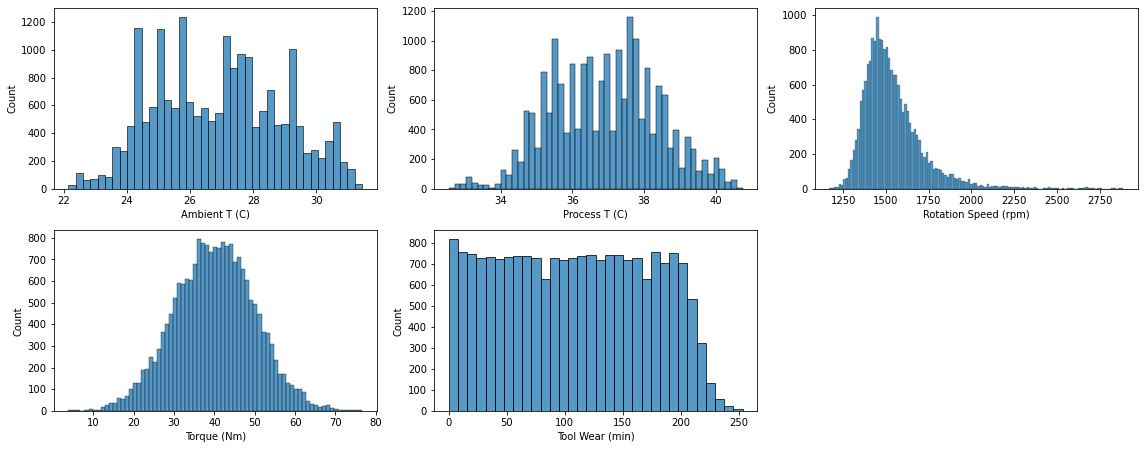

In [13]:
plt.figure(figsize = (16,9))
for i,col in enumerate(['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)']):
    ax = plt.subplot(3,3,i+1)
    sns.histplot(data = imputed , x = col , ax = ax)
plt.tight_layout() 
plt.show()


- `StandardScaler()` should not be used as rotation speed contains outliers, ie (the z score from standardscaler does not apply to non normal distributions)
- Hence, robust scaler should be used as it handles outliers well .

# PCA to alleviate Multicollinearity (for non tree based models)

In [42]:
scaled = imputed.copy()

scaled[['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)']] = RobustScaler().fit_transform(imputed[['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)']]) 
pca = PCA()
pca.fit(scaled[['Torque (Nm)' , 'Rotation Speed (rpm)']] )

def pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['PC {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    #PCA eigenvalues
    ev = pca.explained_variance_.reshape(len(pca.components_), 1)
    eigenvalues = pd.DataFrame(np.round(ev, 4), columns = ['Eigenvalue']) 
    eigenvalues.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat((eigenvalues ,variance_ratios , components)  ,  axis =  1)
print('PCA between Torque and Rotation Speed')
display(pca_results(scaled[['Torque (Nm)' , 'Rotation Speed (rpm)']] , pca))
pca2 = PCA() 
#x= 'Ambient T (C)',  y = 'Process T (C)'
print('Ambient T (C)', 'Process T (C)')

pca2.fit(scaled[['Ambient T (C)', 'Process T (C)']] )
display(pca_results(scaled[['Ambient T (C)', 'Process T (C)']] , pca2))

PCA between Torque and Rotation Speed


Eigenvalue  Explained Variance  Torque (Nm)  Rotation Speed (rpm)
PC 1       1.359              0.9425      -0.5967                0.8025
PC 2       0.083              0.0575       0.8025                0.5967

Ambient T (C) Process T (C)


Eigenvalue  Explained Variance  Ambient T (C)  Process T (C)
PC 1      0.7931              0.9392        -0.6767        -0.7363
PC 2      0.0513              0.0608        -0.7363         0.6767

- We keep the first PC of each PCA as the second componenet only captures  5 or 6% of the total variance, hence the second components are most likely noise that likely to cause overfitting

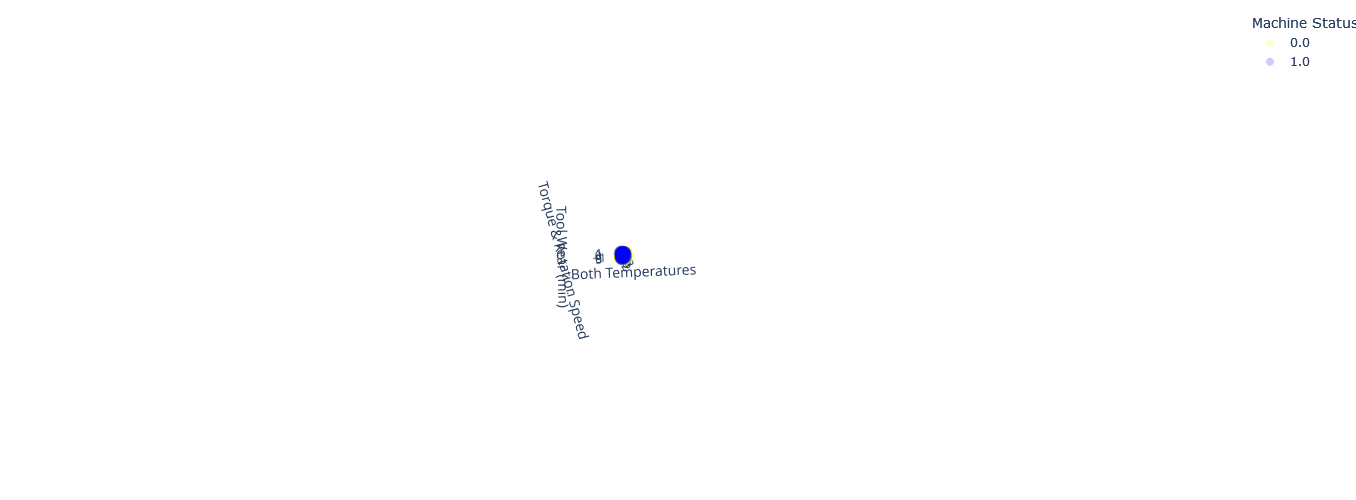

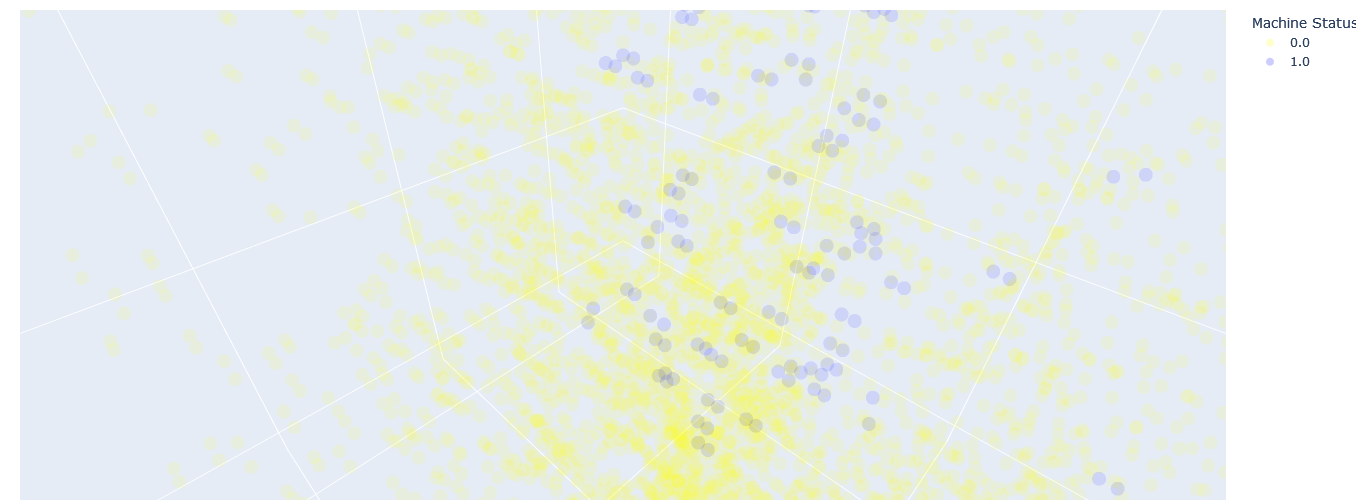

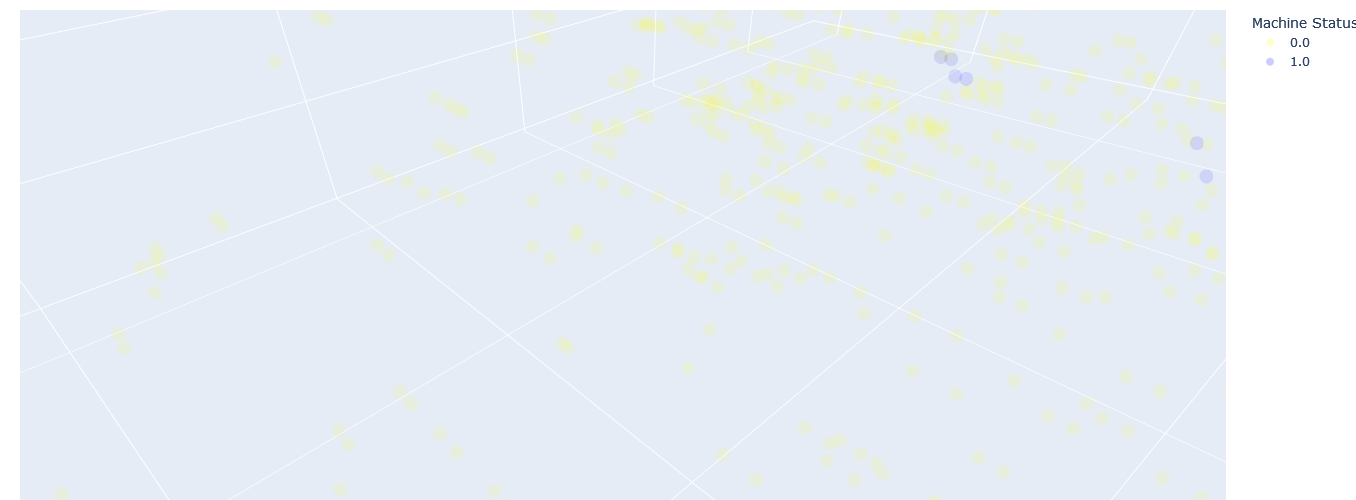

In [43]:
scaled['Torque & Rotation Speed'] =  PCA(n_components = 1).fit_transform(scaled[['Torque (Nm)' , 'Rotation Speed (rpm)']] )
scaled['Both Temperatures'] =  PCA(n_components = 1).fit_transform(scaled[['Ambient T (C)', 'Process T (C)']] )
for q in scaled.Quality.unique():
    temp = scaled[scaled.Quality == q]
    temp['Machine Status'] = temp['Machine Status'].astype(str)
    px.scatter_3d(temp, x='Torque & Rotation Speed', y='Both Temperatures', z='Tool Wear (min)', opacity  = 0.1,
              color='Machine Status'   , width = 900 ,height= 500  , color_discrete_map = {'0.0': 'yellow' , '1.0' :'blue'}).update_layout( margin=dict(l=20, r=10, t=10, b=0) ).show()

- The model will struggle too differenciate between working and faulty machines based on this as points between  are all overlapping
- Hence, more information should be provided to perform feature engineering

# Feature Engineering

- Feature Engineering creates new features from existing features 
- It provides more information to the model, thus making it 'easier' to predict machine status

Torque  and Rotation Speed is connected to each other via:
 $$
 Torque = \frac{Power}{Rotation Speed}
 $$
 which is:
 $$
 Power = {Torque}*{Rotation Speed}
 $$
 From: https://byjus.com/physics/relation-between-torque-and-speed/
 
 
 $$
 TemperatureDifference = {Process T (C)}-{Ambient T (C)}
 $$
 
Machines that are overheating are more likely to be breaking, hence a large difference between the process temperature (operating temperature) and ambient temperature (temperature of the machine not operating)


  $$
 Revolution = {Tool Wear}*{Rotation Speed}
 $$
 
 The total number of revolutions the machine has gone through might also be important

interval columns not set, guessing: ['Quality', 'Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)', 'Machine Status', 'norevolution', 'Power', 'tempdiff', 'noofrevolution']


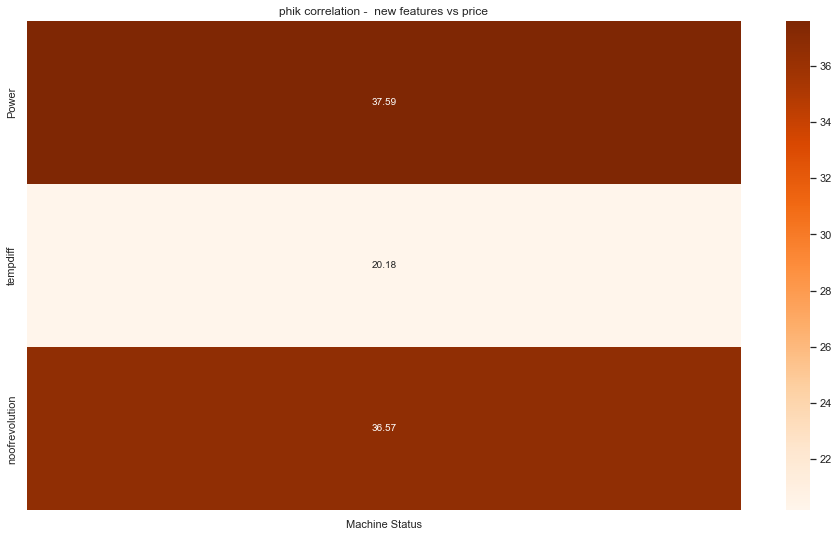

In [73]:
imputed['Power'] = imputed['Torque (Nm)'] * imputed['Rotation Speed (rpm)']
imputed['tempdiff'] = imputed['Process T (C)'] - imputed['Ambient T (C)']
imputed['noofrevolution'] = imputed['Tool Wear (min)'] - imputed['Rotation Speed (rpm)']
sig = np.round(imputed.significance_matrix()  , 2 ).loc[ ['Power' , 'tempdiff' , 'noofrevolution'] , ['Machine Status' ]]
plt.figure(figsize = (16,9))
plt.title("phik correlation -  new features vs price")
sns.heatmap(sig, fmt = ''  , cmap="Oranges"  , annot = sig.astype('string') )
plt.show() 


- Correlations exist between machine status and the power, temperature different and no of revolution
- Hence, they might be useful to the model

# Modeling

#### Choosing a Metric
-	Unbalanced data with 99% working machines (negative class) and 1% faulty machines (Positive Class), hence the need to choose a different evaluation metric from accuracy.
-	the model must be sensitive enough in identifying all faulty machines as faulty
-	It is worse to misclassify faulty machines as working machines than misclassifying working machines as faulty , as faulty machines causes great loss to the business
-	Hence, recall scores are more important than precision
-	The model must also be precise as identifying too many working machines as faulty will cause the model to have no point
-	Hence, f2 score is chosen as it places more weights on the recall score, while not ignoreing precision
-	Tried multiple models to find the models with poor bias variance trade off , overfitting and underfitting models


$$
Precision = \frac{TP}{TP+FP}
$$

$$
Recall = \frac{TP}{TP+FN}
$$



$$
F_2 = 5 * \frac{precision*recall}{4 * precision + recall} = \frac{TP}{TP + 0.2FP + 0.8FN}
$$

Hence we will use F2 Score throughout

In [19]:
from sklearn.model_selection import train_test_split
data = pd.read_csv("factory_data (classification).csv") # dataset loaded in again as all preprocessing is done in pipeline to avoid any data leakage

data.drop(columns = ['Unique ID' , 'Product ID'] , inplace =True)
X = data[[  'Quality' ,  'Torque (Nm)' , 'Tool Wear (min)' , 'Rotation Speed (rpm)' ,'Ambient T (C)', 'Process T (C)'  ]]
y = data['Machine Status']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2   , stratify = y , random_state = rng)
display(X_train , y_train)

Quality  Torque (Nm)  Tool Wear (min)  Rotation Speed (rpm)  \
3530        M         43.7                0                1441.0   
9846        L         58.8               35                1339.0   
4651        L         51.1                9                1349.0   
346         M         45.2               34                1459.0   
4340        M         40.9              106                1533.0   
...       ...          ...              ...                   ...   
8597        L         47.0              191                1410.0   
16901       L         34.5              152                1547.0   
4929        L         44.5               76                1340.0   
14323       L         50.5               64                1341.0   
16527       L         44.4               53                1516.0   

       Ambient T (C)  Process T (C)  
3530           28.75          37.75  
9846           25.15          35.85  
4651           30.05          38.25  
346            24.35          35.15  
4340           28.55          36.75  
...              ...            ...  
8597           24.45          35.15  
16901          27.95          38.65  
4929           30.35          39.25  
14323          28.75          37.25  
16527          28.15          37.35  

[16000 rows x 6 columns]

3530     0
9846     0
4651     1
346      0
4340     0
        ..
8597     0
16901    0
4929     0
14323    1
16527    0
Name: Machine Status, Length: 16000, dtype: int64

### Classes for pipeline

- These classes below are to be placed into a pipeline to prevent data leakage
- if imputation is performed on the whole unsplitted data set then perform test_train_split,

In [44]:
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.ensemble import *
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
from sklearn.linear_model import  Lasso , Ridge , BayesianRidge , LogisticRegression
from sklearn.svm import SVC,SVR
import  sklearn.ensemble as ensem 
import sklearn.tree as tree
from sklearn.neighbors import KNeighborsClassifier , KNeighborsRegressor
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest 
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split , learning_curve , GridSearchCV , validation_curve ,RandomizedSearchCV
from sklearn import svm
from sklearn.neural_network  import MLPClassifier
from sklearn.model_selection import validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score,f1_score, recall_score , precision_score ,  confusion_matrix, fbeta_score , make_scorer

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import RFE
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer,OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer 
from sklearn.decomposition import PCA
from functools import partial 
import pandas as pd 
class Custom_drop(BaseEstimator,TransformerMixin):
    '''To drop a column in the pipeline'''
    def __init__(self,cols ):
        self.cols = cols

    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy.drop(columns = self.cols , inplace =True)
        return  X_copy

class custom_pca(BaseEstimator,TransformerMixin):
    '''To perform PCA on 2 features and keep only the first component'''
    def __init__(self,col1,col2 ):
        self.col1 = col1
        self.col2 = col2

    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        cols = X[[self.col1  , self.col2 ]]
        pca = PCA(n_components = 1 )
        transformedcols =  pca.fit_transform(cols)
        X_copy[self.col1 + '_' + self.col2] = transformedcols
        X_copy.drop(columns = [self.col1 , self.col2])
        return X_copy
    
class NewFeatures(BaseEstimator,TransformerMixin):
    '''Feature engineering in the pipeline after feature engineering'''
    def __init__(self,col1,col2,prod,operator):
        self.col1 = col1
        self.col2 = col2
        self.prod = prod
        self.operator = operator
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):

        X_ = X.copy()

        if self.operator:
            X_[self.prod] = X_[self.col1] - X_[self.col2]
       
            return X_
        else:
            X_[self.prod] = X_[self.col1] * X_[self.col2]
            return X_

        
        
class CustomImputation(BaseEstimator,TransformerMixin):
    '''To impute categorical features and numerical features with null values '''
    def __init__(self,regressor, classifier):
        self.regressor = regressor
        self.classifier = classifier

    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        x_copy = X.copy()

     
        x_copy['Quality'] =  x_copy['Quality'].astype('i' ,  errors='ignore')
        original_quality = x_copy['Quality'].copy()
        temp = IterativeImputer(estimator = self.regressor, random_state=rng).fit_transform(x_copy) #impute numercial features  machine quality here 
      
        x_copy[:] = temp
        x_copy["Quality"] = original_quality
     
        without_null = x_copy[~x_copy.Quality.isnull()].copy()
        without_null.Quality = without_null.Quality.astype('i')
        withnull  = x_copy[x_copy.Quality.isnull()]
        fittedmodel = self.classifier.fit(without_null.drop(columns = ['Quality'])  ,without_null.Quality)
        predictions = fittedmodel.predict(withnull.drop(columns = ['Quality']))
   
        x_copy.loc[x_copy.Quality.isnull(), 'Quality']  = predictions 

        return x_copy




def replace(x , y = None):
    '''To perform ordinal encoding for quality column'''
    x_copy = x.copy()
    x_copy['Quality'] = x_copy['Quality'].map({'L' : 0 , "M" : 1 , 'H' : 2})  
    return x_copy

      
class customScale(BaseEstimator,TransformerMixin):
    '''To perform feature scaling on the categorical variables in the dataset'''
    def __init__(self,scaler):
        self.scaler = scaler
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        x_copy = X.copy()
        cols = x_copy.drop(columns = ['Quality']).columns 
        x_copy[cols] = self.scaler.fit_transform(x_copy[cols]) 
        return x_copy
        



In [45]:


clean = Pipeline([
    ('encoder' , FunctionTransformer(replace)),
    ('impute', CustomImputation( HistGradientBoostingRegressor( random_state = rng ) ,
                                 BaggingClassifier(n_jobs = -1 ,random_state = rng)  )),

   ('power', NewFeatures('Torque (Nm)','Rotation Speed (rpm)','Power', None)),
   ('Temp diff', NewFeatures('Process T (C)', 'Ambient T (C)', 'Temp diff', 'Minus')),
   ('Revolution', NewFeatures('Tool Wear (min)','Rotation Speed (rpm)','Revolution',None)),
  
])

cleanwithscale = Pipeline([
    ('encoder' , FunctionTransformer(replace)),
    ('impute', CustomImputation( HistGradientBoostingRegressor( random_state = rng ) ,
                                 BaggingClassifier(n_jobs = -1 ,random_state = rng)  )),
    
   ('pca1' , custom_pca('Ambient T (C)', 'Process T (C)')), 
    ('pca2'  , custom_pca('Torque (Nm)', 'Rotation Speed (rpm)')),
   ('power', NewFeatures('Torque (Nm)','Rotation Speed (rpm)','Power', None)),
   ('Temp diff', NewFeatures('Process T (C)', 'Ambient T (C)', 'Temp diff', 'Minus')),
   ('Revolution', NewFeatures('Tool Wear (min)','Rotation Speed (rpm)','Revolution',None)),
   ('drop' , Custom_drop(['Ambient T (C)', 'Process T (C)' ,  'Torque (Nm)', 'Rotation Speed (rpm)'])) ,
    ('scale' , customScale( RobustScaler()  ) )   
])


- Most Preprocessing such as Ordinal encoding, imputation is placed in the `Pipeline` to prevent any data leakage
- the `clean` pipeline used for models that are scale invariant and models that not affected by multicollinearity. For e.g `DecisionTree` and `RandomForest` 
- the `cleanwithscale` pipeline usef for models that are scale invariant and models that are affected by multicollinearity for e.g `NeuralNetwork` and `KNN`

In [21]:
def plot_learning_curve(
    X,
    y,
    stepname ,
    estimator  = None,

    ax=None,
    ylim=None,
    steps = None
):

    if steps is not None and estimator is None :
        ax.set_title(steps[-1][0])

        estimator = Pipeline(steps)
    
    #    ax.set_title(estimator.__class__.__name__.replace('Classifier' , ''))
    ax.set_title( stepname)
    if ax is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    if ylim is not None:
        axes[0].set_ylim(*ylim)
        
    ax.set_xlabel("Training examples")
    ax.set_ylabel("F2 Score")

    train_sizes, train_scores, test_scores= learning_curve(
        estimator,
        X,
        y,
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring = make_scorer(fbeta_score  , beta = 2 )  ,
        error_score = 'raise'
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    # Plot learning curve
    
 
    ax.set_ylim(0.0, 1.1)
    labelx = (np.min(train_sizes) + np.max(train_sizes ))/2
    labely = 1.1/2
    ax.grid()
    
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    ax.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    ax.legend(loc="best")
    ax.annotate(f"Final Train F2: {train_scores_mean[-1]:.2f} \n Final Cross Validation F2: {test_scores_mean[-1]:.2f}" , (labelx,labely), c = "white" , ha = 'center',va ='center' , bbox = dict(fc = "black", alpha = 0.7, boxstyle = "Round, pad=0.45") )

    return plt

# Model Selection

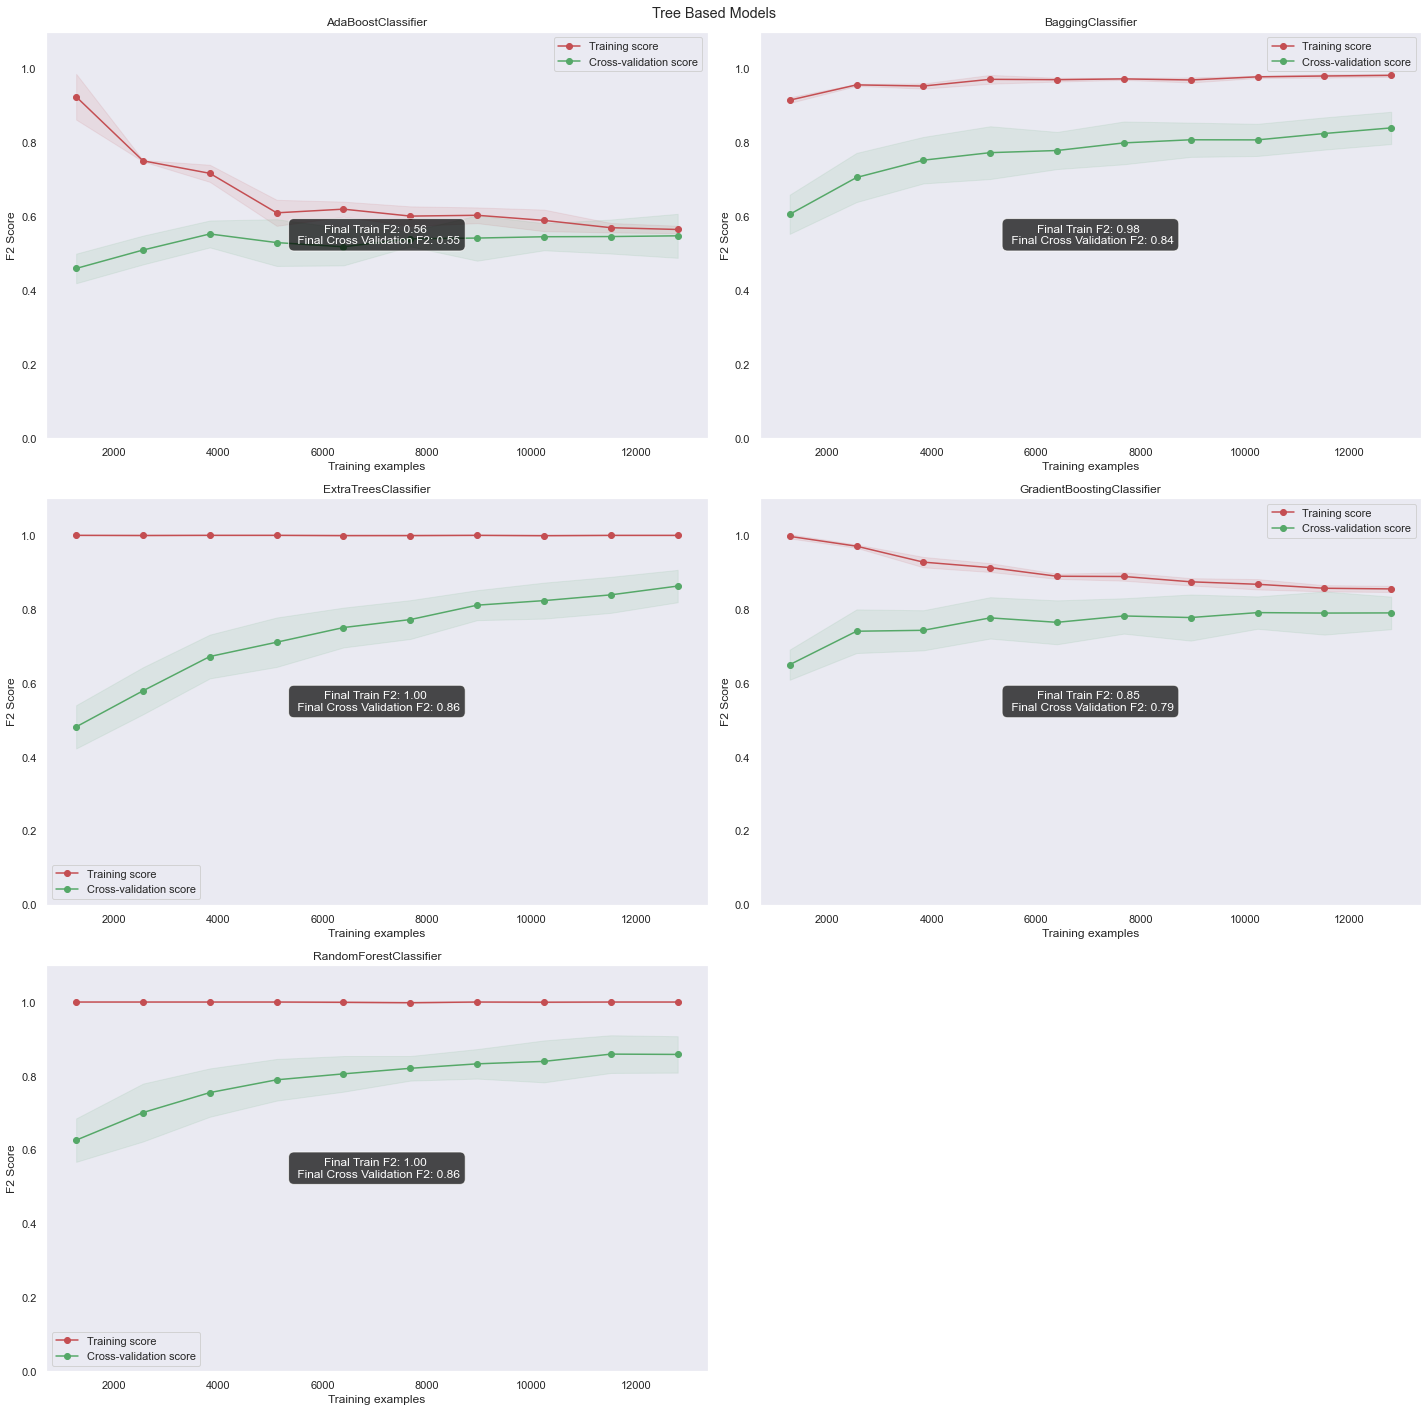

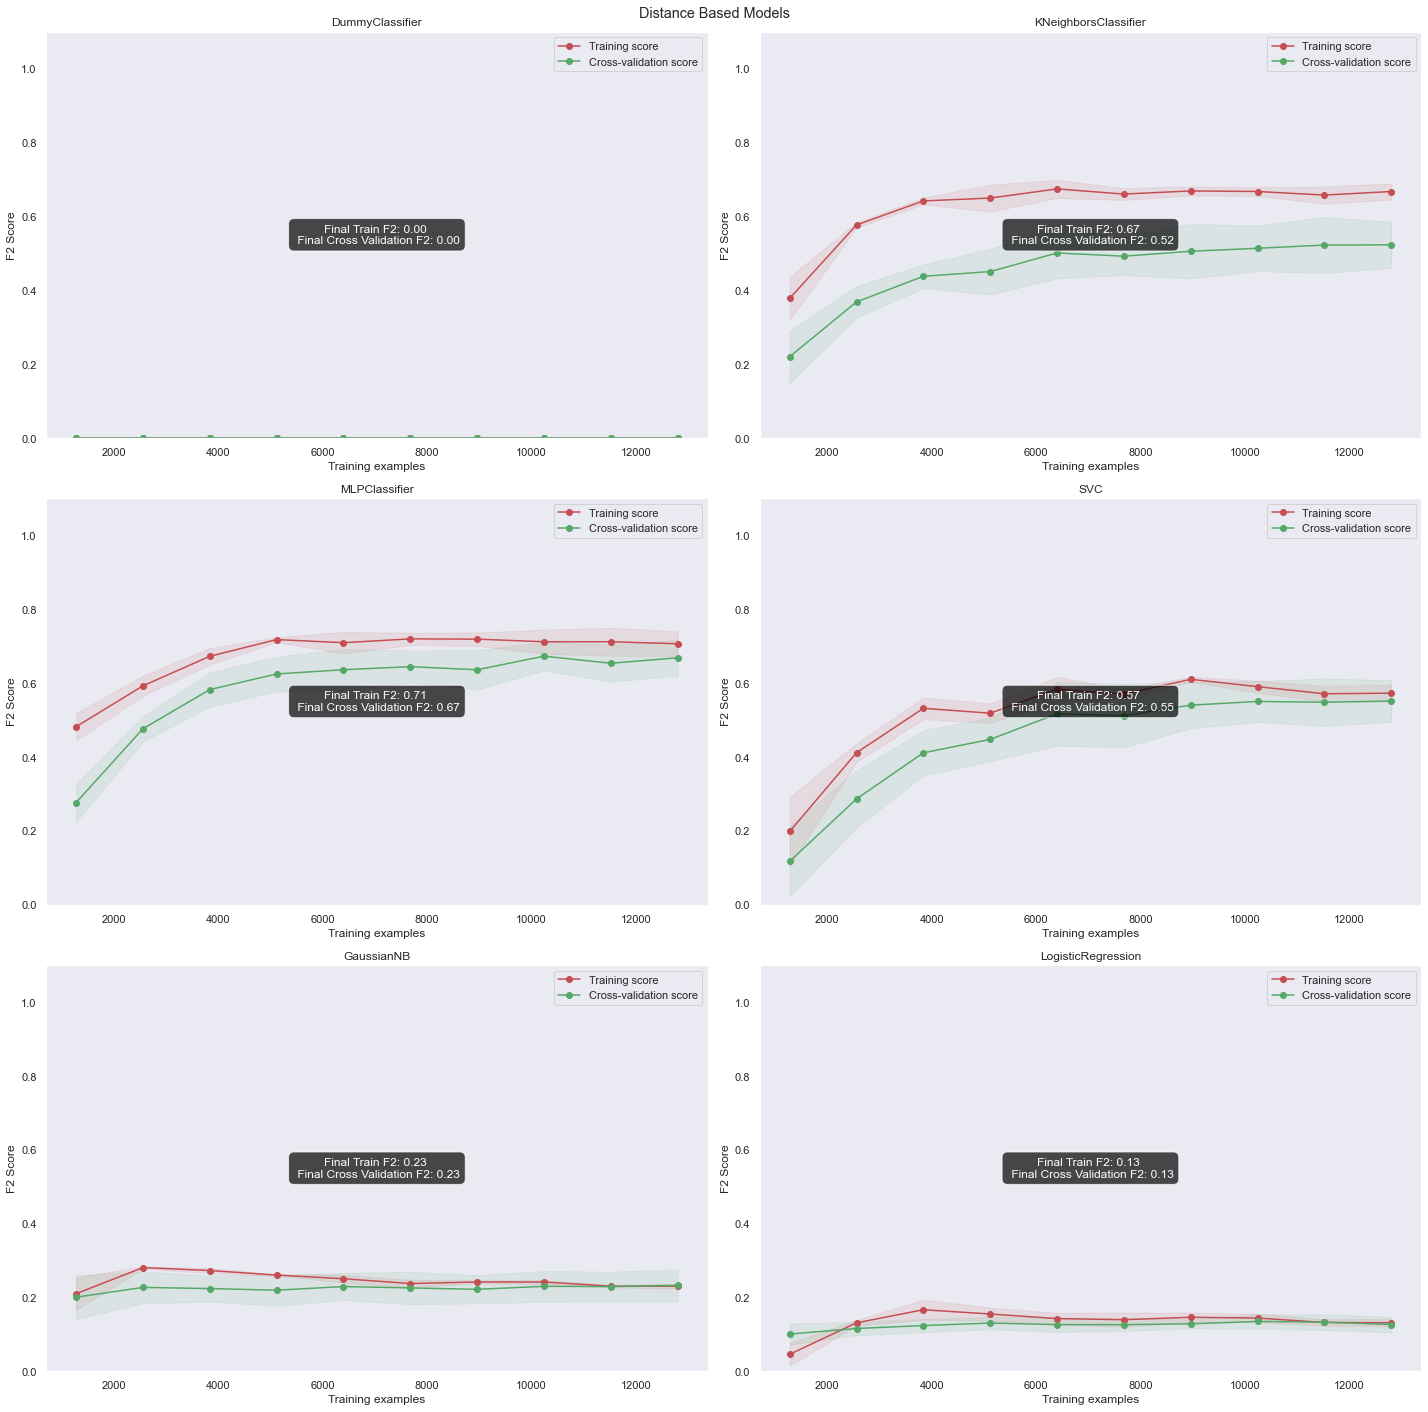

In [22]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import fbeta_score , make_scorer
from sklearn.pipeline import  Pipeline
from sklearn.preprocessing import RobustScaler , FunctionTransformer 
import seaborn as sns 
from sklearn.tree import DecisionTreeClassifier
sns.set() 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
plt.figure(figsize = (20,20))
from sklearn.ensemble import * 
from sklearn.base import BaseEstimator,TransformerMixin


        

plt.gcf().suptitle('Tree Based Models')
treebasedmodels = [AdaBoostClassifier(random_state = rng),BaggingClassifier(random_state = rng) , ExtraTreesClassifier(random_state = rng) ,GradientBoostingClassifier(random_state = rng) ,RandomForestClassifier(random_state = rng)   ]


pipe = Pipeline([
     ('preprocess' , clean),
     ("model", DummyClassifier()   )
])

for i , m in enumerate(treebasedmodels):
    pipe.set_params( **{ 'model' : m})
    plot_learning_curve(estimator = pipe , X = X_train, stepname = m.__class__.__name__, y = y_train , ax = plt.subplot(3,2, i+1))
    

plt.tight_layout()
plt.show() 
plt.figure(figsize = (20,20))

plt.gcf().suptitle('Distance Based Models')

pipe = Pipeline([
     ('preprocess' , cleanwithscale),
     ("model", DummyClassifier()   )
])

distancedbasedmodels = [DummyClassifier() , KNeighborsClassifier() ,MLPClassifier() ,  SVC() , GaussianNB() ,  LogisticRegression() ]
for i , m in enumerate(distancedbasedmodels):
    pipe.set_params( **{ 'model' : m})
    plot_learning_curve( X = X_train, y = y_train   , stepname = m.__class__.__name__ , ax = plt.subplot(3,2, i+1) , estimator = pipe )

plt.tight_layout()
plt.show() 

#### Underfitting Models 

1. `DummyClassifier`
- performs very poorly with an f2 score of 0, as it simply predicts all machines to be working, leading to recall of 0  (hence f2 = 0) as none of the faulty machines (true positive) is predicted as positive 

2. `KNeighbours`
-  F2 score increases initially but pleateau out quickly at around 0.5 and 0.6 for cross validation and train set respectively
3. `Neural Network`
- Slightly better than `KNeighbours` but still underfitting
4. `SVM`
- Underfitting with poor final cv score
5. `GaussianNB`
6. `LogisticRegression`
- consistently low f2 score for both Gaussian NB and Logistic Regression
7. `Adaboost`

#### Slightly overfiting models 
1. `ExtraTrees`
2. `Bagging`
3. `Random Forest`

`Random Forest` is chosen as it has the highest f2 score 


### Pipeline

In [23]:
pipe = Pipeline([
     ('preprocess' , cleanwithscale),
     ("model", RandomForestClassifier(n_jobs = -1 , random_state = rng )   )
])

From here onwards the imputation  and feature creation  is placed in the pipeline to prevent data leakage 

[0.99926148 0.99926233 0.99889265 0.99889265 0.99926148]


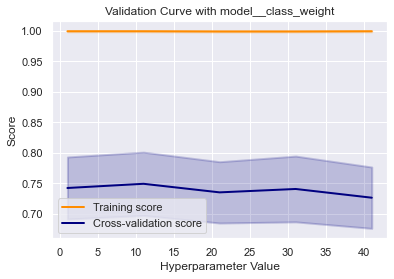

In [24]:
def custom_validation_curve(paramname, param_range  , ax , X_train, y_train  ,model,plotvalues): 
    #to plot  validation curve for each hyper parameter
    train_scores, test_scores = validation_curve(
        model,
        X_train,
        y_train,
        param_name=paramname,
        param_range=param_range,
        scoring=make_scorer(fbeta_score , beta =2 ) ,
        n_jobs=-1,
        cv = StratifiedKFold(n_splits = 5 , shuffle = True , random_state = rng),
         
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print(train_scores_mean)

    ax.set_title(f"Validation Curve with {paramname}")
    ax.set_xlabel('Hyperparameter Value')
    ax.set_ylabel("Score")
  #  ax.set_ylim(0.0, 1.1)
    lw = 2
    ax.plot(
    plotvalues, train_scores_mean, label="Training score", color="darkorange", lw=lw
    )
 
    ax.fill_between(
        plotvalues,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
  
    ax.plot(
    plotvalues, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
    )
    ax.fill_between(
        plotvalues,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    
    ax.legend(loc="best")
plt.figure( )
weights = []

for i in np.arange(1,51 ,10):
    weights.append( {0: 1 , 1 : i })
custom_validation_curve('model__class_weight',weights , plt.gca() ,X_train, y_train ,pipe  ,    np.arange(1,51 ,10))
plt.show( )

- Attempt to place more weights on the rarer class (positive class/faulty machines ), so that theres is lower chance of misclassifying faulty machine on  the lower class
- Despite Putting more weights on the postive examples (which are more rare) the model did not improve and the model is overfitting even more as the weight placed on the positive class increases

# Hyperparameter Tuning

- Before tuning, validation curves are plotted to figure out the ranges where the best hyperparameters are most likely to be found

model__bootstrap
model__criterion
model__max_depth
model__min_samples_split
model__n_estimators
model__max_features


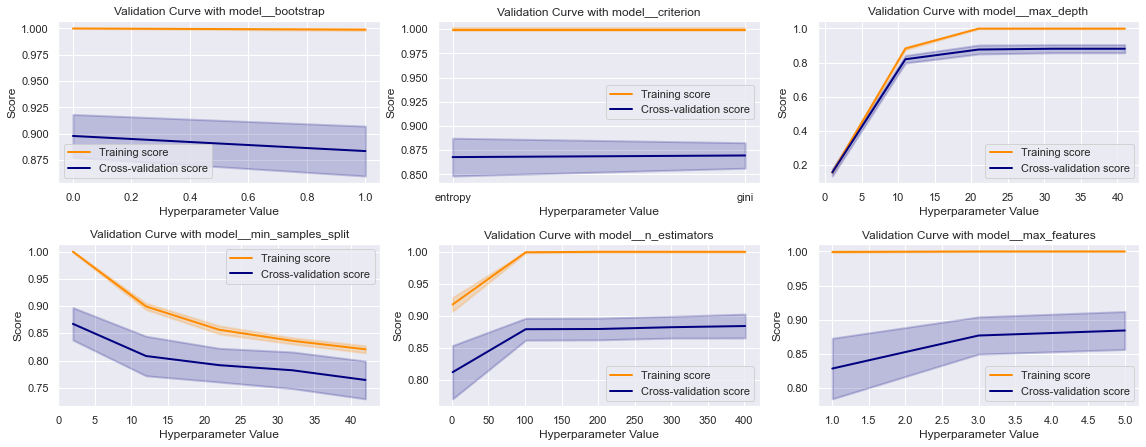

In [25]:


pipe = Pipeline([
     ('preprocess' , clean),
     ("model", RandomForestClassifier(random_state = rng   ,
                                      n_jobs = -1  )   )
])

grid = {'model__bootstrap' :  [ True , False]  , 
        'model__criterion' : ['entropy' , 'gini'],
        'model__max_depth' : np.arange(1,51,10 , dtype = int ), 
        'model__min_samples_split' : np.arange(2,52,10 , dtype = int)  ,
        'model__n_estimators' : np.arange(1, 501 , 100),
        'model__max_features' : np.arange(1,6,2) }
def custom_validation_curve(paramname, param_range  , ax , X_train, y_train  ,model): 
    #to plot  validation curve for each hyper parameter
    print(paramname) 
    train_scores, test_scores = validation_curve(
        model,
        X_train,
        y_train,
        param_name=paramname,
        param_range=param_range,
        scoring=make_scorer(fbeta_score , beta =2 ) ,
        n_jobs=-1,
        cv = StratifiedKFold(n_splits = 5 , shuffle = True , random_state = rng)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.set_title(f"Validation Curve with {paramname}")
    ax.set_xlabel('Hyperparameter Value')
    ax.set_ylabel("Score")
  #  ax.set_ylim(0.0, 1.1)
    lw = 2
    ax.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
    )
 
    ax.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
  
    ax.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
    )
    ax.fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    
    ax.legend(loc="best")

# roughTuning = GridSearchCV( pipe ,grid, n_jobs = -1 , scoring = 'f1' , cv = 3 , verbose = 3)

# roughTuning.fit(X_train , y_train )
plt.figure(figsize = (16,9)) 
from  multiprocessing import cpu_count
#grid = {'model__max_features' : np.arange(1,6,2) }
#Parallel(n_jobs=cpu_count()  , verbose = 3 )(delayed(partial(custom_validation_curve , X_train = X_train , y_train = y_train , model = pipe))(pname,prange, plt.subplot(3,3,i+1) ) for i, (pname,prange)  in enumerate(grid.items()))
for i, (pname,prange)  in enumerate(grid.items()):
    custom_validation_curve(pname,prange, plt.subplot(3,3,i+1) ,X_train, y_train ,pipe )
plt.tight_layout() 
plt.show() 

### Summary of Validation Curves
- Hyperparameters controls the bias variance trade off
These are how they affect Random Forest in General
- max_depth : higher depth leads to more variance and less bias (less underfitting)
- min_sample_split : Larger minimum number of samples required for a split leads to more bias and less variance (less overfitting)
- n_estimators : more estimators (decision trees) would average out the errors made by each estimator due to high variance of each individual decision tree, more estimators leads to lower variance higher bias



Bootstraping |criterion | max_depth| min_samples_split | n_estimators | max_features 
:-------------------|:---------------|:---------------|:---------------|:---------------|:--------------------
No boostraping is better | Both criterion is similar in term of mean and standard deviation, <br> entropy is  randomly chosen| Better above 25 |  Best when kept at Minimum of 2 | Better above 200 | Better above 3

In [32]:
from sklearn.base import clone 


pipe = Pipeline([
     ('preprocess' , clean),
     ("model", RandomForestClassifier(random_state = rng   ,
                                      n_jobs = -1  )   )
])
paramgrid = {'model__bootstrap' :  [  False]  , 
        'model__criterion' : ['entropy' ],
        'model__max_depth' : np.arange(25,35 ,2, dtype = int ), 
        'model__min_samples_split' : [2],
        'model__n_estimators' : np.arange(250, 350, 20),
        'model__max_features' :[3,4,5 ]}
tuning = GridSearchCV( pipe ,paramgrid, n_jobs = -1 , scoring = make_scorer(fbeta_score, beta =2 ) , cv = 5 , verbose = 3  )

tuning.fit(X_train , y_train )
print('best params' , tuning.best_params_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
best params {'model__bootstrap': False, 'model__criterion': 'entropy', 'model__max_depth': 25, 'model__max_features': 4, 'model__min_samples_split': 2, 'model__n_estimators': 250}


In [33]:
pipe.set_params( ** tuning.best_params_);

# Threshold Moving
- For Precision Recall Tradeoff 

In [35]:
from joblib import Parallel, delayed
from functools import partial
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from  multiprocessing import cpu_count
from sklearn.base import clone 
from sklearn.metrics import fbeta_score
def multicore_speedup(train_index, test_index , X_train , y_train , X_traincols  , model  , threshold   ):
    model = clone(model ) #make sure the pipeline is unfitted 
    X_traincv, X_testcv = X_train[train_index], X_train[test_index]
    y_traincv, y_testcv = y_train[train_index], y_train[test_index]
   # print(X_traincv , y_traincv )
    X_traincv = pd.DataFrame( X_traincv , columns = X_traincols)
    X_testcv = pd.DataFrame( X_testcv , columns = X_traincols)
    try:
        
        model.fit(X_traincv , y_traincv)
    except :
        return -1
    y_pred = (model.predict_proba(X_testcv)[:,1] >= threshold).astype(bool)
    
 
    return (fbeta_score(y_testcv , y_pred , beta = 2  ))


def each_threshold(threshold ,  split , X_train , y_train   , model ,  X_traincols):
    results_per_threshold = Parallel(n_jobs=cpu_count(), verbose=50)(delayed( partial ( multicore_speedup,  threshold  = threshold, X_train =  X_train, y_train  = y_train , X_traincols = X_traincols  , model = model) )
                                                    (train_index , test_index )for train_index, test_index  in split.split(X_train, y_train)) 
    print(results_per_threshold )
    return {'threshold':threshold ,'f2_mean': np.mean(results_per_threshold) , 'f2_standard deviation' : np.std(results_per_threshold )}
    
    
def tune_threshold(model , X_train, y_train    , thresholds ):
    best_thresholds = []
    best_f2s =  []
    X_traincols = X_train.columns
    X_train = X_train.values
    y_train = y_train.values
 #   equal_parts = np.array_split(data.sample(frac=1), 5)  #manuel 5 fold cross validation
    split = StratifiedKFold(n_splits=5 , random_state = rng  , shuffle = True )
   # split.split(X_train, y_train 
  #  for threshold in thresholds:
    
    results =  Parallel(n_jobs=cpu_count(), verbose=50)(delayed( partial( each_threshold , split = split  , X_train =  X_train, y_train  = y_train , X_traincols = X_traincols  , model = model) )
                                                    (threshold)for threshold in thresholds )
    return  pd.DataFrame(results)#.sort_values( 'f2'  , ascending = False ).loc[0  , 'threshold' ]
    
results = tune_threshold(pipe ,X_train   , y_train  , [0.1,0.2,0.3,0.4,0.5])
print('best threshold for f2 is ')  
display( results)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:  6.5min
[Parallel(n_jobs=16)]: Done   2 out of   5 | elapsed:  6.6min remaining: 10.0min
[Parallel(n_jobs=16)]: Done   3 out of   5 | elapsed:  6.9min remaining:  4.6min
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=16)]: Done   5 out of   5 | elapsed:  6.9min finished
best threshold for f2 is 


threshold   f2_mean  f2_standard deviation
0        0.1  0.891301               0.023727
1        0.2  0.910023               0.021392
2        0.3  0.911912               0.031589
3        0.4  0.900615               0.028834
4        0.5  0.890490               0.035395

- The Random Forest output the probability that a machine is faulty 
- The model then uses the default threshold 0.5
- This threshold control precision recall tradeoff
- i.e (if the output probability is > 0.5 the machine is  considered faulty and not faulty if output probability < 0.5 ). The default threshold places equal importance on recall and precision ) 
- Threshold < 0.5 mean it is more important to correctly identify that most/all machines that are faulty are predicted as faulty, thus favouring better f2 score 
- alter the threshold of the model as lower thresholds (0.1, 0.2 , 0.3 , 0.4 ) below 50 will favour better f2 score 
- Lowering the threshold has improved the f2 cross validation scores 
- Threshold of 0.3 is chosen for its best f2 score

# Final Evaluation

In [74]:
pipe.fit(X_train,y_train)

from sklearn.metrics import fbeta_score
predictions = (pipe.predict_proba(X_test)[:,1] >= 0.3).astype(bool)
print('precision' , precision_score(y_test, predictions))
print('recall' , recall_score(y_test, predictions))
print('f1'  ,f1_score(y_test ,predictions ) )
print('f2' , fbeta_score(y_test ,predictions  ,  beta = 2 ))
print("confusion matrix" ,matrix :=  confusion_matrix(y_test ,predictions ) , sep = '\n')


precision 0.9712230215827338
recall 0.9926470588235294
f1 0.9818181818181818
f2 0.9882869692532942
confusion matrix
[[3860    4]
 [   1  135]]


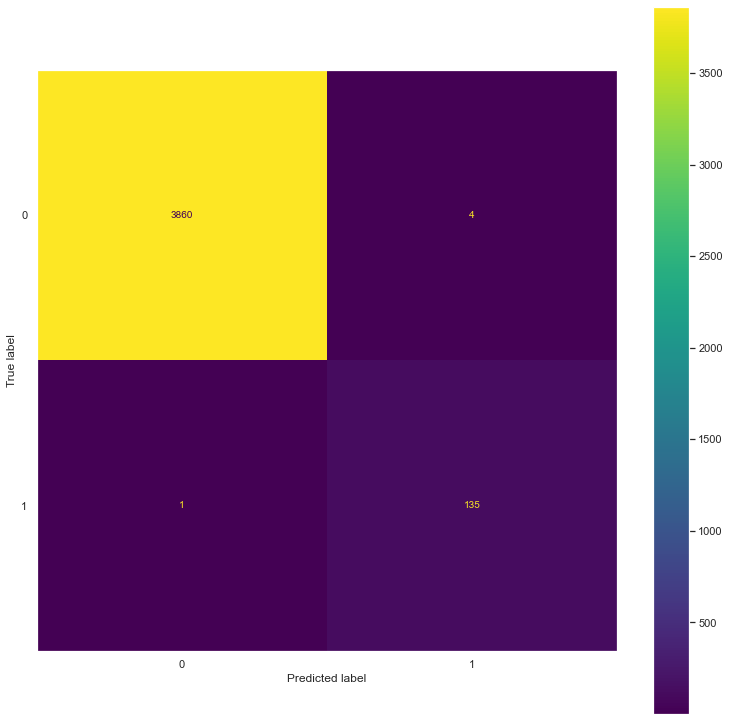

In [79]:
#confusion matrix 
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(figsize = (13,13))
plt.grid(False)
ConfusionMatrixDisplay.from_predictions(y_test, predictions , ax = plt.gca())
plt.show() 

- We achieved f2 score of 0.988, recall of 0.992 and precision of 0.971 
- There is 1 machine that is predicted as faulty but predicted as not faulty
- 4 Machines that are not faulty that are predicted as faulty

# Feature Importance

In [89]:
# Feature importances
idx = ['Quality', 'Torque (Nm)', 'Tool Wear (min)', 'Rotation Speed (rpm)','Ambient T (C)', 'Process T (C)' , 'Power', 'Temp Diff (C)', 'Revolutions']
importance = pd.DataFrame(pipe.named_steps["model"].feature_importances_,index=idx,columns=['Importance'])
sortidx= pd.DataFrame(importance['Importance'].sort_values(ascending=False)).index
lbl = importance['Importance'].sort_values(ascending=False).round(3)

pd.DataFrame(lbl*100)

Importance
Power                       20.0
Rotation Speed (rpm)        17.4
Torque (Nm)                 17.3
Tool Wear (min)             14.5
Temp Diff (C)               14.0
Revolutions                  7.6
Ambient T (C)                4.8
Process T (C)                2.9
Quality                      1.5

- The Feature importances show the most important feature is `Power` from feature engineering, taking up 20% of the total importance. Its phik correlation with price is  37.59 while that of torque is 0.586 showing the relationships found by the rule based RandomForest is non linear (phik correlation only detects  linear relationships)
- Temperature difference has importance of 14% while the ambient and process temperature only has importances of 4.8% and 2.9%, thus showing how feature engineering by creating new features, helps the model in predictions

# Conclusion 
- Through EDA, feature engineering , model choosing and hyperparameter tuning, we have created a model that is sensitive enough to identify all the faulty machine, while also quite precise that quite little machines that are not faulty are identified as faulty. Hence, our model should be able to save some cost for the company by fixing the identified faulty machines before they actually mulfunction